In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Overview

This notebook demonstrates a retrieval augemented generation (RAG) approach to product attribute generation.

It assumes the the product category is already known. For detecting product category see 3_product_categorization.ipynb

It consists of the following steps, each of which is expanded upon in the respective sections below:

1. Retrieve nearest neighbors

2. Extract descriptions and attributes from neighbors

3. Construct LLM Prompt

4. Generate Attributes

5. Evaluation

6. Anomaly Detection


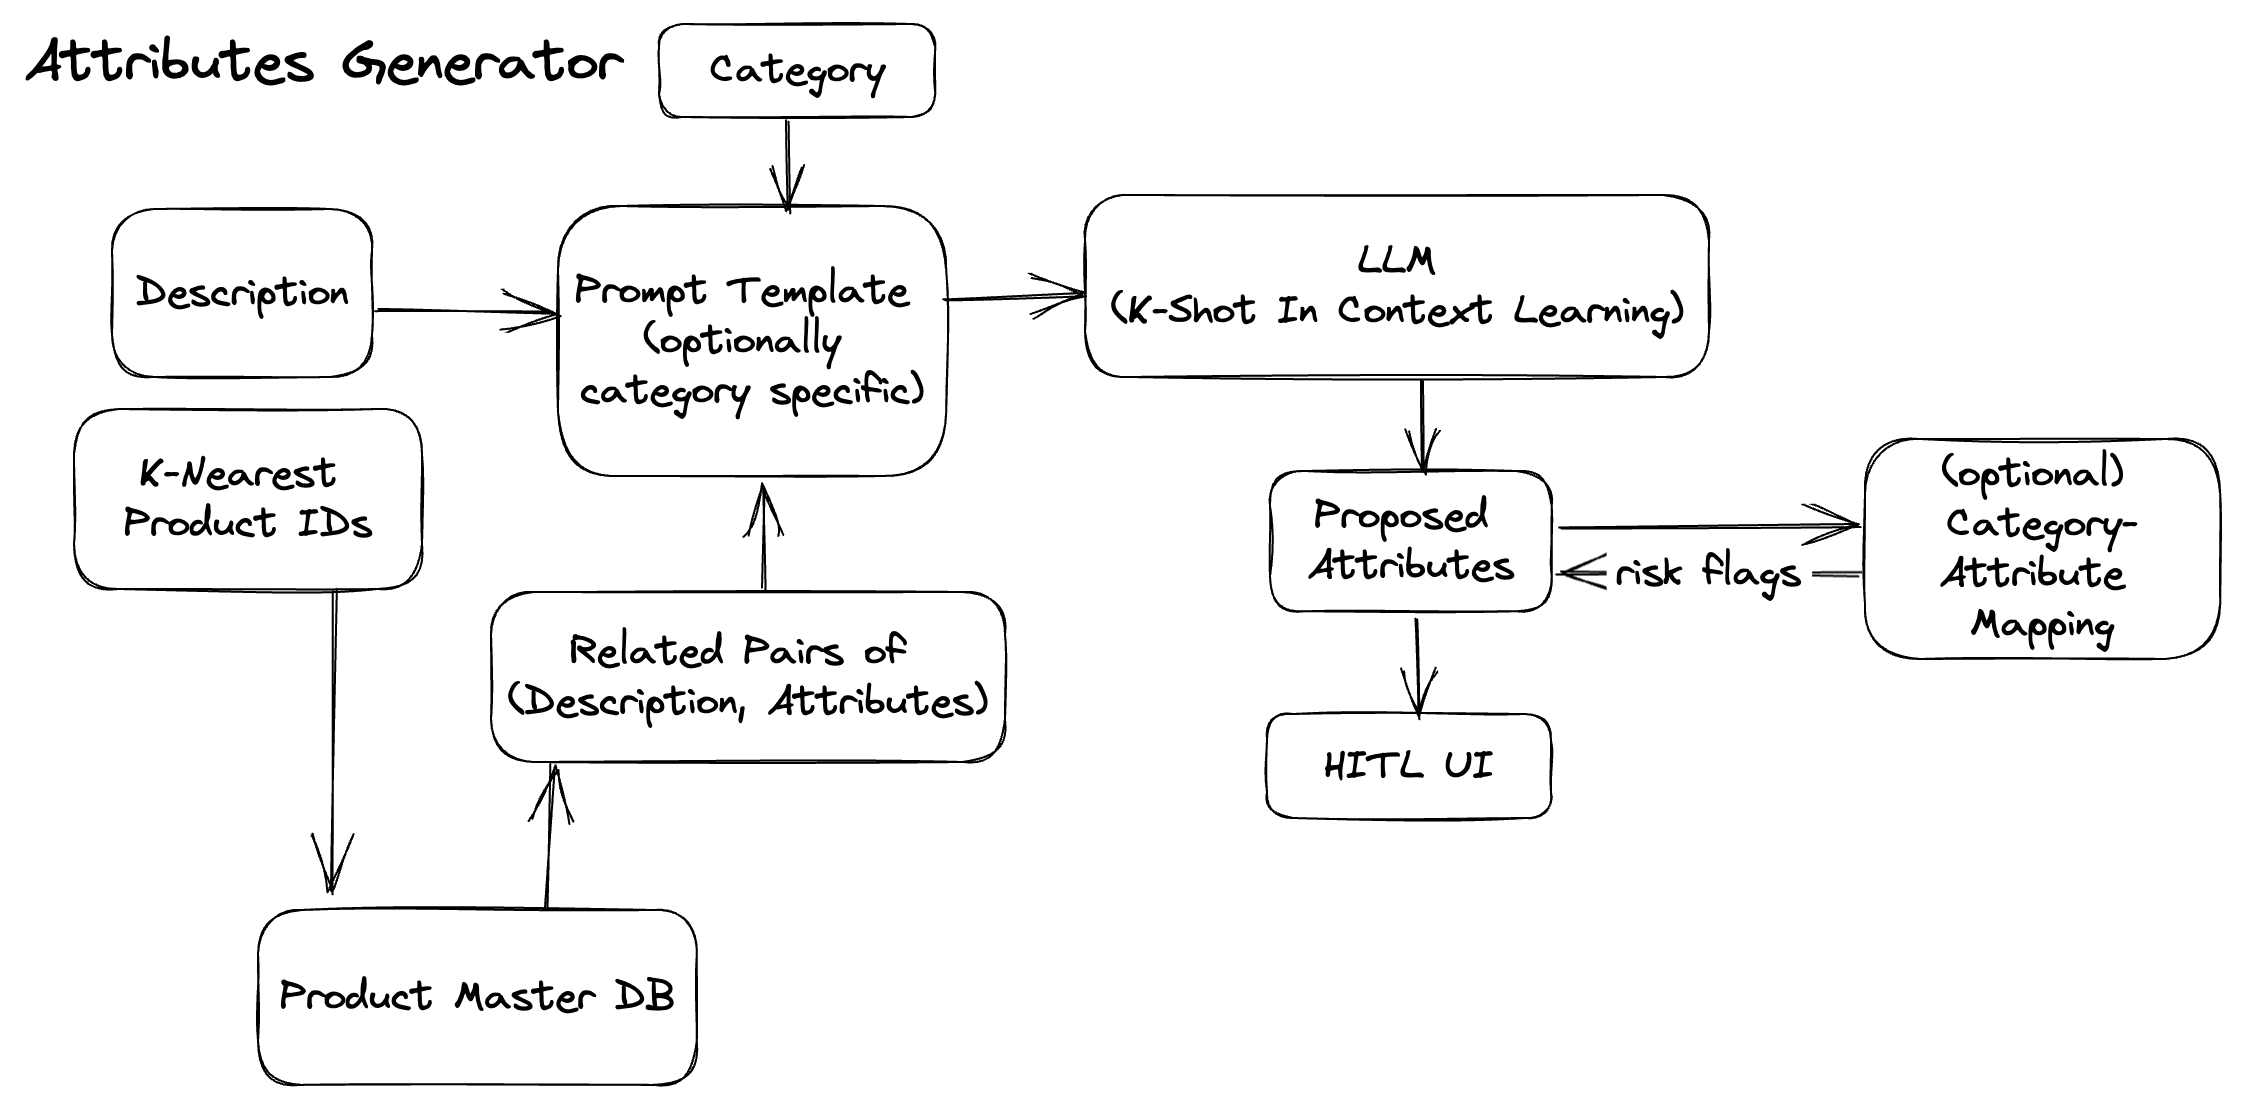

# Setup

### Install Dependencies (If Needed)

The list `packages` contains tuples of package import names and install names. If the import name is not found then the install name is used to install quitely for the current user.

In [ ]:
# tuples of (import name, install name)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

installing package google-cloud-aiplatform
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.7 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [ ]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

### Authenticate

If you are using Colab, you will need to authenticate yourself first. The next cell will check if you are currently using Colab, and will start the authentication process.

If you are using Vertex AI Workbench, you will not require additional authentication.

In [ ]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import auth as google_auth
    google_auth.authenticate_user()

### Imports

In [1]:
# Standard Library
import sys

# PyPi
from google.cloud import aiplatform
from google.cloud import bigquery

# Local Project Code
sys.path.insert(0, '../backend/')
import embeddings
import nearest_neighbors

### Config

In [2]:
# GCP
PROJECT = 'solutions-2023-mar-107'
LOCATION = 'us-central1'

# Vertex Vector Store
ENDPOINT_ID = '8767655253467201536'
DEPLOYED_INDEX = 'muiltimodal_13K_train'
NUM_NEIGHBORS = 7 # Fetches NUM_NEIGBHORS for both text and image embeddings

# BigQuery
MASTER_PRODUCT_TABLE = 'solutions-2023-mar-107.mercari.13K_synthetic_attributes_embeddings'
TEST_SET_TABLE = 'solutions-2023-mar-107.mercari.13K_synthetic_attributes_embeddings_golden_test'

# 0. Inputs

End user provides an image and a short product description. We also assume we know the category.

In [3]:
DESCRIPTION = "New Men’s Nike Sportswear Storm-Fit Hooded Puffer Jacket   Retail~$200  The down insulation offers a lightweight construction that packs in the heat. Nike Storm-FIT technology resists elements like wind and water to help keep you comfortable in harsh weather conditions. Zippered hand pockets offer secure storage for essentials like your phone, wallet and keys. Raised silicone logo patch. Storm-FIT embroidery on the cuff highlights the premium construction. Standard fit for a relaxed, easy feel  Men's Size XXL Condition: New with tags  Color: Grey  Please feel free to ask questions   Thanks for looking"
IMAGE_URL = 'gs://genai-product-catalog/mercari_images_13K/m92378019981_1.jpg'
CATEGORY = ''

# 1. Fetch K Nearest Neighbors

This notebooks assumes a Vertex Vector Search Index with product image and text embeddings is already deployed. For instructions on that see 2_create_vector_db.ipynb.

Note at inference time we may be provided an image, a description, or both. This will result in 1-2 embeddings, and we will return the nearest neighbors for each. Because images and text share an embedding space, images can be used to find related text and and text and be used to find related images.

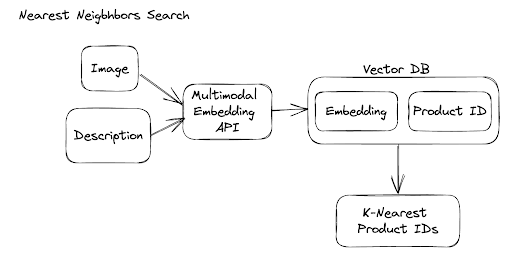



In [4]:
emb = embeddings.embed(DESCRIPTION,IMAGE_URL,project=PROJECT)

print(emb.text_embedding[:5])
print(emb.image_embedding[:5])

[0.00849247724, -0.0554532409, -0.0026236705, 0.0393719375, 0.00585184852]
[-0.00685360376, 0.02130723, 0.0321788564, 0.00949654263, 0.0263511892]


In [5]:
response = nearest_neighbors.get_nn([emb.text_embedding,emb.image_embedding], NUM_NEIGHBORS)
response


[Neighbor(id='m92707982024_T', distance=0.4626591205596924),
 Neighbor(id='m43369638843_T', distance=0.4913021922111511),
 Neighbor(id='m95009287541_T', distance=0.5149260759353638),
 Neighbor(id='m16679973173_T', distance=0.5184187293052673),
 Neighbor(id='m29453375264_T', distance=0.5201120376586914),
 Neighbor(id='m49593492937_T', distance=0.5226439237594604),
 Neighbor(id='m90437332747_T', distance=0.5279781818389893),
 Neighbor(id='m11961150187_I', distance=0.29012882709503174),
 Neighbor(id='m61502985617_I', distance=0.3507727384567261),
 Neighbor(id='m57687708636_I', distance=0.35484778881073),
 Neighbor(id='m11189242705_I', distance=0.36963629722595215),
 Neighbor(id='m23486085804_I', distance=0.36991220712661743),
 Neighbor(id='m68453215119_I', distance=0.37831687927246094),
 Neighbor(id='m53091189782_I', distance=0.39109504222869873)]

# 2. Extract Descriptions and Attributes

The Vector DB does not contain reference information such as category, description and attributes. It only returns a product ID. We join this against the master product reference table in BigQuery

In [6]:
bq_client = bigquery.Client(PROJECT)

def get_topk_nearestn_attributes(product_ids: str):
  """Gets the description and attributes for a given product IDs.

  Args:
      product_id: The product ID to get the description and attributes for.
  """
  query = f"""
  SELECT
    id,
    c0_name,
    c1_name,
    c2_name,
    description,
    attributes
  FROM
    `{MASTER_PRODUCT_TABLE}`
  WHERE
    id IN {str(product_ids).replace('[','(').replace(']',')')}
  """
  query_job = bq_client.query(query)
  rows = query_job.result()
  prompt_str = ''
  attributes = []
  for row in rows:
    attributes += row['attributes']
  return attributes

ids = [r.id[:-2] for neighbor in response for r in neighbor]
examples = get_topk_nearestn_attributes(ids)

print(examples)

AttributeError: 'str' object has no attribute 'id'

In [ ]:

bq_client = bigquery.Client(PROJECT)

def get_topk_description_and_attributes(product_ids: str):
  """Gets the description and attributes for a given product IDs.

  Args:
      product_id: The product ID to get the description and attributes for.
  ids = [r.id[:-2] for neighbor in response for r in neighbor]
  """
  query = f"""
  SELECT
    id,
    c0_name,
    c1_name,
    c2_name,
    description,
    attributes
  FROM
    `{MASTER_PRODUCT_TABLE}`
  WHERE
    id IN {str(product_ids).replace('[','(').replace(']',')')}
  """
  query_job = bq_client.query(query)
  rows = query_job.result()
  prompt_str = ''
  for row in rows:
    prompt_str += 'Description:\n' + row['description']+'\n'
    prompt_str += 'Attributes: ' + ', '.join(row['attributes'])+'\n\n'
  return prompt_str

ids = [r.id[:-2] for neighbor in response for r in neighbor]
examples = get_topk_description_and_attributes(ids)

print(examples)

Description:
NWT Nike One 7" Women's Shorts Training Sport Smoke/Grey Mid Rise Shorts 

•Size Small
•BRAND NEW With TAGS 
•7”
•Mid Rise 

 ALWAYS Fast shipping

Any questions please feel free to ask
Offers ALWAYS Welcome
Make me an OFFER
Attributes: Joint, Outerwear, Shoulder, Leg, Human body, Neck, Sleeve, Waist, Thigh, Standing

Description:
Nike Sportswear Tech Pack Unlined Gilet Vest DM5534-737 Mens Size XL NWT
Attributes: Brown, Product, Sleeve, Collar, T-shirt, Sleeveless shirt, Font, Beige, Peach, Fashion accessory

Description:
Nike windbreaker jacket. No rips or tears just some pilling on the cuffs. Size XS. Retail price was 100 and im selling it for 45% off
Attributes: Clothes hanger, Sleeve, T-shirt, Grey, Silver, Fashion design, Font, Collar, Automotive design, Fashion accessory

Description:
New with Tags - New Nike Men's Contend 9-inch Volley Swim Trunks Game Royal Heather
Mens Size X-Large 
Find your comfort zone at the pool or beach with these men's Nike volley shorts.


In [ ]:
bq_client = bigquery.Client(PROJECT)

def get_attributes_from_category(c0, c1, c2):
  """Gets the description and attributes for a given product IDs.

  Args:
      product_id: The product ID to get the description and attributes for.
  ids = [r.id[:-2] for neighbor in response for r in neighbor]
  """

  query = f"""
  SELECT
    id,
    c0_name,
    c1_name,
    c2_name,
    description,
    attributes
  FROM
    `{MASTER_PRODUCT_TABLE}`
  WHERE
    c0_name = "{c0}"
  AND
    c1_name = "{c1}"
  AND
    c2_name = "{c2}"
  """

  query_job = bq_client.query(query)
  rows = query_job.result()
  prompt_str = ''
  attributes = []
  for row in rows:
    attributes += row['attributes']
  return attributes

examples = get_attributes_from_category("Men", "Shorts", "Denim")

print(examples)

['Brown', 'Sleeve', 'Beige', 'Collar', 'Rectangle', 'Tints and shades', 'Font', 'Button', 'Magenta', 'Wood', 'Sleeve', 'Shorts', 'Denim', 'Tints and shades', 'Undergarment', 'Fashion design', 'Trunks', 'Pattern', 'Pocket', 'Shade', 'Shorts', 'Trunks', 'Sleeve', 'Bermuda shorts', 'Electric blue', 'board short', 'Pattern', 'Denim', 'Pocket', 'Font']


# 3. Construct LLM Prompt

Given the user input description, the category, and information about the nearest neigbhor products, construct an LLM Prompt

In [ ]:
import vertexai
from vertexai.language_models import TextGenerationModel
vertexai.init(project=PROJECT, location=LOCATION)
parameters = {
    "max_output_tokens": 256,
    "temperature": 0.0,
}

## Category Agnostic Prompt

Using the (description, attribute) pairs of the K nearest neighbors, we construct a K-shot learning prompt of the following form

```
Following are examples of Product Descriptions followed by Attributes

Description 1:.....
Attributes 1:....

Description 2:...
Attributes 2:....

Generate attributes for the following description…

Description:...
Attributes:
```

In [ ]:
from os import strerror
def create_query_from_topk(description: str, candidates: list[list[str]],examples:str) -> tuple[list[str], str]:
  """Generate Attributes"""

  query = f"""

Take the given 20 items in the attribute list and only keep the 10 attributes that best match the description. Delete the other 10 items.
Your answer should be a list of 10 items that are comma separated

Attribute List: {candidates}

Description: {description}
Best Matching Attributes:"""

  return query

query = create_query_from_topk(DESCRIPTION,'response',examples)

In [ ]:
from os import strerror
def create_query(description: str, candidates: list[list[str]],examples:str) -> tuple[list[str], str]:
  """Generate Attributes"""

  query = f"""

Here are examples of Product Descriptions followed by Attributes

{examples}

Generate 10 attributes based on the description below. Make sure your attributes are comma separated list.

Description: {description}
Attributes:
"""

  return query

query = create_query(DESCRIPTION,'response',examples)
print(query)



Here are examples of Product Descriptions followed by Attributes

Description:
NWT Nike One 7" Women's Shorts Training Sport Smoke/Grey Mid Rise Shorts 

•Size Small
•BRAND NEW With TAGS 
•7”
•Mid Rise 

 ALWAYS Fast shipping

Any questions please feel free to ask
Offers ALWAYS Welcome
Make me an OFFER
Attributes: Joint, Outerwear, Shoulder, Leg, Human body, Neck, Sleeve, Waist, Thigh, Standing

Description:
Nike Sportswear Tech Pack Unlined Gilet Vest DM5534-737 Mens Size XL NWT
Attributes: Brown, Product, Sleeve, Collar, T-shirt, Sleeveless shirt, Font, Beige, Peach, Fashion accessory

Description:
Nike windbreaker jacket. No rips or tears just some pilling on the cuffs. Size XS. Retail price was 100 and im selling it for 45% off
Attributes: Clothes hanger, Sleeve, T-shirt, Grey, Silver, Fashion design, Font, Collar, Automotive design, Fashion accessory

Description:
New with Tags - New Nike Men's Contend 9-inch Volley Swim Trunks Game Royal Heather
Mens Size X-Large 
Find your com

In [ ]:
model = TextGenerationModel.from_pretrained("text-bison")

def get_attributes(query:str):
  """
  This function takes a query string as input and returns a list of attributes
  predicted by the language model.

  Args:
    query: A string query.

  Returns:
    A list of predicted attributes.
  """
  response = model.predict(
      query,
      **parameters)
  llm_attributes = response.text.strip().replace(", ", ",").replace("/n", "").split(",")
  return llm_attributes

attributes = get_attributes(query)
attributes

['Sleeve',
 'Grey',
 'Collar',
 'T-shirt',
 'Sportswear',
 'Outerwear',
 'Jacket',
 'Zipper',
 'Polyester',
 'Pocket']

In [ ]:
model = TextGenerationModel.from_pretrained("text-bison")

def get_attributes_curated(query:str):
  """
  This function takes a query string as input and returns a list of attributes
  predicted by the language model.

  Args:
    query: A string query.

  Returns:
    A list of predicted attributes.
  """
  response = model.predict(
      query,
      **parameters)
  print("response: " + str(response.text))
  split_lines = response.text.split("\n")
  print(split_lines)
  split_lines = [x for x in split_lines if x]
  print(split_lines)
  num_lines = len(split_lines)

  try:
    llm_attributes = split_lines[num_lines-1].strip().replace(", ", ",").replace("/n", "").split(",")
  except:
    llm_attributes = split_lines[0].strip().replace(", ", ",").replace("/n", "").split(",")

  return llm_attributes

attributes = get_attributes_curated(query)
attributes

response:  Sleeve, Grey, Collar, T-shirt, Sportswear, Baby & toddler clothing, Font, Pattern, Outerwear, Jacket
[' Sleeve, Grey, Collar, T-shirt, Sportswear, Baby & toddler clothing, Font, Pattern, Outerwear, Jacket']
[' Sleeve, Grey, Collar, T-shirt, Sportswear, Baby & toddler clothing, Font, Pattern, Outerwear, Jacket']
1


['Sleeve',
 'Grey',
 'Collar',
 'T-shirt',
 'Sportswear',
 'Baby & toddler clothing',
 'Font',
 'Pattern',
 'Outerwear',
 'Jacket']

# 4a. Evaluation for Method 1: Retrieval Without Generation

In this section we will perform a heuristic attribution method which will take the most popular attributes from the topK nearest neighbor retrieval method. The goal is to see if simple retrieval and aggregation can give us good results even before using the Large Language Model.

In [ ]:
query = f"""
  SELECT
    id,
    name,
    description,
    image_uri,
    attributes,
    url,
    c0_name,
    c1_name,
    c2_name,
    train_val_count
  FROM
    `{TEST_SET_TABLE}`
  WHERE
    manual_validation = 1 AND
    train_val_count >= 1
"""
df = bq_client.query(query).to_dataframe()
df.head()

,id,name,description,image_uri,attributes,url,c0_name,c1_name,c2_name,train_val_count
0,m87595910019,Hot Sweat Sauna Body Shaper Women Slimmi,SAME DAY Free SHIPPING Hot Sweat Sauna Body ...,gs://genai-product-catalog/mercari_images_13K/...,['Clothing' 'Joint' 'Outerwear' 'Shoulder' 'Wh...,https://www.mercari.com/us/item/m87595910019,Women,Underwear,Thermal underwear,1
1,m99091941411,Minnesota Twins Baseline Boppers Baseball Bobb...,Very good vintage condition. Set of 2 Minnesot...,gs://genai-product-catalog/mercari_images_13K/...,['Land vehicle' 'Wheel' 'Vehicle' 'Toy' 'Tire'...,https://www.mercari.com/us/item/m99091941411,Toys & Collectibles,Vintage & Antique Toys,Sports,1
2,m69723132745,Coach wristlet,Coach leather wristlet with Minnie Mouse on th...,gs://genai-product-catalog/mercari_images_13K/...,['Bag' 'Sleeve' 'Rectangle' 'Beige' 'Material ...,https://www.mercari.com/us/item/m69723132745,Handmade,Bags and purses,Wristlet,1
3,m18721424768,Fujifilm Instax Mini 11 Instant Film Camera in...,New Fujifilm Instax Mini 11 Instant Film Camer...,gs://genai-product-catalog/mercari_images_13K/...,['Camera lens' 'Camera' 'Camera accessory' 'Di...,https://www.mercari.com/us/item/m18721424768,Electronics,Cameras & photography,Film & Polaroid Cameras,2
4,m56226905309,Rough Natural Charm Streetwear Kawaii Denim Je...,GS02_040123_1 Preowned in used condition. Rar...,gs://genai-product-catalog/mercari_images_13K/...,['Shorts' 'Trunks' 'Sleeve' 'Bermuda shorts' '...,https://www.mercari.com/us/item/m56226905309,Men,Shorts,Denim,2


In [ ]:
from collections import Counter

def get_nearestn_attributes_pipeline(row, topk):
  '''Gets the top k attributes of a product based on its description and image.

  Args:
    row: A row from the dataset.
    topk: The number of attributes to return.

  Returns:
    A list of the top k attributes.
  '''

  nearest_n = get_nearest_neighbors(my_index_endpoint, PROJECT,
                                     row["description"], row["image_uri"],
                                     NUM_NEIGHBORS)
  product_ids = [r.id[:-2] for neighbor in nearest_n for r in neighbor]
  list_of_attributes = get_topk_nearestn_attributes(product_ids)
  examples = get_topk_description_and_attributes(product_ids)

  counts = Counter(list_of_attributes)
  top_k_attributes = [
      attribute for attribute, count in counts.most_common(topk)
  ]
  return top_k_attributes


#test
print(df.iloc[0])
print(get_nearestn_attributes_pipeline(df.iloc[0], 10))

id                                                      m87595910019
name                        Hot Sweat Sauna Body Shaper Women Slimmi
description        SAME DAY Free SHIPPING   Hot Sweat Sauna Body ...
image_uri          gs://genai-product-catalog/mercari_images_13K/...
attributes         ['Clothing' 'Joint' 'Outerwear' 'Shoulder' 'Wh...
url                     https://www.mercari.com/us/item/m87595910019
c0_name                                                        Women
c1_name                                                    Underwear
c2_name                                            Thermal underwear
train_val_count                                                    1
Name: 0, dtype: object
['Sleeve', 'Neck', 'Waist', 'Thigh', 'Sports gear', 'Sportswear', 'Personal protective equipment', 'Font', 'Electric blue', 'Shoe']


Run attributes pipeline for all rows in dataset

In [ ]:
# run if you haven't run attribute generation before

#df_small = df#.head(5)
#df_small["generated_attributes_mthd1"] = df_small.apply(lambda x: str(get_nearestn_attributes_pipeline(x, 10)), axis=1)
#df_small.to_gbq(str(TEST_SET_TABLE)+"_w_gen_attr_mthd1", project_id=PROJECT, if_exists='replace')

In [ ]:
# else just load your data
import pandas as pd
df_test = pd.read_gbq(str(TEST_SET_TABLE)+"_w_gen_attr")

In [ ]:
df_test.head(5)

,id,name,description,image_uri,attributes,url,c0_name,c1_name,c2_name,train_val_count,generated_attributes_mthd1
0,m56226905309,Rough Natural Charm Streetwear Kawaii Denim Je...,GS02_040123_1 Preowned in used condition. Rar...,gs://genai-product-catalog/mercari_images_13K/...,['Shorts' 'Trunks' 'Sleeve' 'Bermuda shorts' '...,https://www.mercari.com/us/item/m56226905309,Men,Shorts,Denim,2,"['Sleeve', 'Electric blue', 'Denim', 'Font', '..."
1,m67375259941,Mens FootJoy 1/4 Zip Tonal Heather Golf Pullov...,Size 2Xl Made in Vietnam 100% Polyester Tonal ...,gs://genai-product-catalog/mercari_images_13K/...,['Sleeve' 'Grey' 'T-shirt' 'Collar' 'Active sh...,https://www.mercari.com/us/item/m67375259941,Men,Athletic apparel,Athletic Sweatshirts,2,"['Sleeve', 'Collar', 'T-shirt', 'Blazer', 'Pat..."
2,m92378019981,$200 New Men's Nike Sportswear Storm-Fit Hoode...,New Men’s Nike Sportswear Storm-Fit Hooded Puf...,gs://genai-product-catalog/mercari_images_13K/...,['Brown' 'Outerwear' 'Textile' 'Sleeve' 'Colla...,https://www.mercari.com/us/item/m92378019981,Men,Coats & jackets,Puffer,4,"['Sleeve', 'Collar', 'T-shirt', 'Grey', 'Font'..."
3,m49638171223,"Mens Chaps Golf shorts, grey size 36","Grey men’s Chaps Golf shorts, like new size 36",gs://genai-product-catalog/mercari_images_13K/...,['Outerwear' 'Sleeve' 'T-shirt' 'Shorts' 'Grey...,https://www.mercari.com/us/item/m49638171223,Men,Shorts,Cargo,10,"['Sleeve', 'Shorts', 'Textile', 'Trunks', 'Den..."
4,m92248813386,Men’s Black Nike Jogger Sweatpants Size Large,Men’s Black Nike Jogger Sweatpants Size Large ...,gs://genai-product-catalog/mercari_images_13K/...,['Active shorts' 'Sleeve' 'Grey' 'Denim' 'Tint...,https://www.mercari.com/us/item/m92248813386,Men,Sweats & hoodies,Sweat Pants,12,"['Sleeve', 'Denim', 'Sportswear', 'Electric bl..."


This evaluation function leverage semantic similarity to get the precision and recall of the generated attributes vs the real attributes.

Instead of doing exact matching, semantic matching will check to see if there are similar attributes in the test data set. If there are it will mark the generated attributes as correct.

Semantic similarity works by taking the dot product of two embeddings. Therefore you will get a value between 0 and 1. The next step is to define a similarity threshold that helps to mark it as correct vs. incorrect. This threshold can be set anywhere from 0 to 1 where 0 will match everything as correct and 0.999 will check for exact matching.

Take this example:

ground_truth_list = ["The", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog"]

predicted_list = ["The", "fast", "maroon", "fox","hops", "over", "the", "lazy", "canine"]

With a similarity threshold of 0.7 it will give you and F1 score of 1.0. Now when we set the threshold is 0.99 then the F1 will be 0.55.


In [ ]:
from vertexai.preview.language_models import TextEmbeddingModel
import numpy as np

emb_model = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")

def str_to_ls(x):
  return x.replace("[", "").replace("]", "").replace("  ", " ").replace("' '", ",").replace("'","").split(",")

# this one is quicker since it does not have to call the text emb api
def exact_match(text_one, text_two):

  if text_one == text_two:
    return 1
  else:
    return 0

# this one is slow since it is making a call to the embedding api
def do_they_match(text_one, text_two, threshold):

  try:
    embedding_response = emb_model.get_embeddings([text_one, text_two])
  except Exception as e:
    print(e)
    raise

  embeddings = [embedding.values for embedding in embedding_response]

  similarity = np.dot(embeddings[0], embeddings[1])

  if similarity >= threshold:
    return 1
  else:
    return 0


def get_match_precision_and_recall(ground_truth_list, predicted_list,
                                   similarity_threshold, match_type):
  """
  Calculates the match precision and recall for two lists of words, ignoring order.

  Args:
    ground_truth_list: A list of ground truth words.
    predicted_list: A list of predicted words.
    similarity_threshold: only applies for semantic match
    match_type: takes two values "exact" and "semantic"

  Returns:
    A tuple of (precision, recall).
  """

  # Create a set of the ground truth words.
  ground_truth_set = set(ground_truth_list)
  predicted_set = set(predicted_list)

  # Calculate the number of correct predictions.
  num_match_predictions = 0
  for predicted_word in predicted_set:
    for gt_word in ground_truth_set:

      # get matching score between two words
      if match_type == "exact":
        matches = exact_match(predicted_word, gt_word)
      elif match_type == "semantic":
        matches = do_they_match(predicted_word, gt_word,similarity_threshold)
      else:
        raise ValueError("match_type must be either 'exact' or 'semantic'")

      if matches:
        num_match_predictions += 1
        break # move on to the next word


  # Calculate f1 score.
  precision = num_match_predictions / len(predicted_set)
  recall = num_match_predictions / len(ground_truth_set)
  if precision + recall == 0:
    f1 = 0
  else:
    f1 = 2 * (precision * recall) / (precision + recall)

  return f1, precision, recall

In [ ]:
#semantic match
from tqdm import tqdm
tqdm.pandas()

In [ ]:
df_test['f1'] = df_test.progress_apply(lambda x: get_match_precision_and_recall(
                                          str_to_ls(x["attributes"]),
                                          str_to_ls(x["generated_attributes_mthd1"]),
                                          0.8, "semantic"
                                        ), axis=1)
f1_mean = df_test["f1"].apply(lambda x: x[2]).mean()
print("F1 score: " + str(f1_mean))

100%|██████████| 115/115 [14:01<00:00,  7.31s/it]

F1 score: 0.4893581780538302


In [ ]:
#exact match

df_test['f1'] = df_test.apply(lambda x: get_match_precision_and_recall(
                                          str_to_ls(x["attributes"]),
                                          str_to_ls(x["generated_attributes_mthd1"]),
                                          0.8, "exact"
                                        )[0], axis=1)
f1_mean = df_test["f1"].mean()
print("F1 score: " + str(f1_mean))

F1 score: 0.08405015095282965


# 4b. Evaluation for Method 2: RAG with Few Shot Prompting

Using our test set, let's evaluate the accuracy of our prompt using precision and recall. Note automated metrics are noisey since whether an attribute is 'correct' is subjective. For example 'Jacket' and 'Outerwear' are similar attributes but if only 'Jacket' is in the test attribute set 'Outerwear' will be considered wrong. While automated metrics are still directionally useful for evaluation at scale, they should be supplemented with human analysis

## Run Batch Job for Attribute Generation

For a given row in the golden test dataset do the following:
1. get nearest neighbors based on image embedding and text embedding
2. get the description and attributes for the nearest neighbor products
3. create the prommpt/ query
4. get the attributes from the prompt and query

In [ ]:
def get_attributes_pipeline(row):
  nearest_n = get_nearest_neighbors(my_index_endpoint, PROJECT,
                                     row["description"], row["image_uri"],
                                     NUM_NEIGHBORS)
  product_ids = [r.id[:-2] for neighbor in nearest_n for r in neighbor]
  examples = get_topk_description_and_attributes(product_ids)
  query = create_query(row["description"], "",examples)
  attributes = get_attributes(query)
  return attributes

# an example for one row
print("url: " + str(df_test.iloc[0]["url"]))
print("description: " + str(df_test.iloc[0]["description"]))
print("real attributes: " + str(df_test.iloc[0]["attributes"]))
print("generated attributes: " + str(get_attributes_pipeline(df_test.iloc[0])))

url: https://www.mercari.com/us/item/m58138208645
description: Levi’s CLASSIC  WESTERN STANDARD FIT SHIRT Size Medium  Color black washed  Good condition!
real attributes: ['Outerwear' 'Textile' 'Sleeve' 'Grey' 'Collar' 'Wood' 'Denim' 'Button'  'Font' 'Pattern']
generated attributes: ['Sleeve', 'Dress shirt', 'Collar', 'T-shirt', 'Grey', 'Button', 'Pattern', 'Electric blue', 'Brand', 'Fashion accessory']


In [ ]:
df_test["generated_attributes_mthd2"] = df_test.progress_apply(lambda x: str(get_attributes_pipeline(x)), axis=1)
df_test.to_gbq(str(TEST_SET_TABLE)+"_w_gen_attr", project_id=PROJECT, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 756.14it/s]


In [ ]:
# (OPTIONAL) if you have already run and save you can load your generated attributes here
#import pandas as pd
#df_test = pd.read_gbq(str(TEST_SET_TABLE)+"_w_gen_attr")

In [ ]:
df_test.head(5)

,id,name,description,image_uri,attributes,url,c0_name,c1_name,c2_name,train_val_count,generated_attributes_mthd1,f1,generated_attributes_mthd2,generated_attributes_mthd4,generated_attributes_mthd3
0,m58138208645,levis western jean Shirt,Levi’s CLASSIC WESTERN STANDARD FIT SHIRT Size Medium Color black washed Good condition!,gs://genai-product-catalog/mercari_images_13K/m58138208645_1.jpg,['Outerwear' 'Textile' 'Sleeve' 'Grey' 'Collar' 'Wood' 'Denim' 'Button' 'Font' 'Pattern'],https://www.mercari.com/us/item/m58138208645,Men,Tops,Button-front,88,"['Sleeve', 'Grey', 'Collar', 'T-shirt', 'Electric blue', 'Pattern', 'Outerwear', 'Dress shirt', 'Fashion accessory', 'Denim']",0.133333,"['Sleeve', 'Dress shirt', 'Collar', 'T-shirt', 'Grey', 'Button', 'Pattern', 'Electric blue', 'Brand', 'Fashion accessory']","['Sleeve', 'Collar', 'Dress shirt', 'Pattern', 'Grey', 'Blazer', 'Tartan', 'Textile', 'T-shirt']","['Sleeve', 'Collar', 'T-shirt', 'Dress shirt', 'Denim', 'Button', 'Sportswear', 'Tartan', 'Clothes hanger', 'Black']"
1,m29958147788,Luffy One Piece Pirates Anime Manga Unisex Tshirt T-shirt Tee All Sizes7801,"""Please message me if you want to buy another shirt or other size, can design according to your requirements..."" Product Detail • Brand : Gildan - Gildan Heavy Cotton Unisex T-Shirt - 5.3 oz/yd², 100% Cotton - Seamless double-needle 7/8″ collar - Double-needle sleeve and bottom hems - Quarter-turned to eliminate center crease - Preshrunk jersey knit, Taped neck and shoulders - Classic fit tubular body, Classic midweight fabric - Decoration Type Digital Print - Production Time : 3 - 5 Business Days - Shipping Time : 2 - 7 Business Days Digitally printed shirt",gs://genai-product-catalog/mercari_images_13K/m29958147788_1.jpg,['Sports uniform' 'Jersey' 'Sports jersey' 'Sleeve' 'Sportswear' 'T-shirt' 'Font' 'Active shirt' 'Uniform' 'Pattern'],https://www.mercari.com/us/item/m29958147788,Men,Tops,T-shirts,355,"['Font', 'Sleeve', 'T-shirt', 'Grey', 'Baby & toddler clothing', 'Active shirt', 'Sportswear', 'Magenta', 'Fictional character', 'Carmine']",0.000000,"['Sleeve', 'Grey', 'T-shirt', 'Baby & toddler clothing', 'Font', 'Active shirt', 'Sportswear', 'Brand', 'Fictional character', 'Magenta']","['T-shirt', 'Active shirt', 'Sportswear', 'Product', 'Jersey', 'Sleeve', 'Grey', 'Font', 'Outerwear', 'Baby & toddler clothing']","['T-shirt', 'Brand', 'Gildan', 'Sleeve', 'Jersey', 'Cotton', 'Design', 'Fabric', 'Print', '衫']"
2,m67521461320,Crown and Ivy Cabana Tie Dye Men T Shirt Men’s,Beautiful Tie Dye Cotton Poly Blend 60/40. So soft and quality,gs://genai-product-catalog/mercari_images_13K/m67521461320_1.jpg,['Brown' 'Orange' 'Sleeve' 'T-shirt' 'Baby & toddler clothing' 'Wood' 'Collar' 'Line' 'Font' 'Rectangle'],https://www.mercari.com/us/item/m67521461320,Men,Tops,T-shirts,355,"['Sleeve', 'T-shirt', 'Pattern', 'Font', 'Baby & toddler clothing', 'Outerwear', 'Grey', 'Collar', 'Electric blue', 'Neck']",0.125000,"['Sleeve', 'T-shirt', 'Pattern', 'Textile', 'Grey', 'Magenta', 'Aqua', 'Pink', 'Baby & toddler clothing', 'Electric blue']","['Sleeve', 'T-shirt', 'Active shirt', 'Sportswear', 'Product', 'Jersey', 'Cotton', 'Polyester', 'Blend', 'Soft']","['Sleeve', 'T-shirt', 'Pattern', 'Grey', 'Electric blue', 'Neck', 'Dress', 'Magenta', 'Textile', 'One-piece garment']"
3,m31681592173,Sublime Long Beach Neon Wavy Sun Rock L/S 2X,Sublime Long Beach Neon Wavy Sun Rock L/S 2X approx measures 26 inches pit to pit and 29 inches long never worn first hand overstock great condition,gs://genai-product-catalog/mercari_images_13K/m31681592173_1.jpg,['Shirt' 'Blue' 'Sleeve' 'Collar' 'Font' 'Baby & toddler clothing' 'T-shirt' 'Electric blue' 'Dress shirt' 'Button'],https://www.mercari.com/us/item/m31681592173,Men,Tops,T-shirts,355,"['Sleeve', 'Font', 'T-shirt', 'Product', 'Sportswear', 'Grey', 'Outerwear', 'Neck', 'Textile', 'Pattern']",0.000000,"['Sleeve', 'T-shirt', 'Outerwear', 'Product', 'Neck', 'Jersey', 'Sleeve', 'Grey', 'Sportswear', 'T-shirt',

### Run the evaluation for the golden test dataset.


In [ ]:
#df_small = df.head(5)

df_test['f1'] = df_test.progress_apply(lambda x: get_match_precision_and_recall(
                                          str_to_ls(x["attributes"]),
                                          str_to_ls(x["generated_attributes_mthd2"]),
                                          0.8, "semantic"
                                        ), axis=1)
f1_mean = df_test["f1"].apply(lambda x: x[2]).mean()
print("F1 score: " + str(f1_mean))

100%|██████████| 115/115 [26:04<00:00, 13.61s/it]

F1 score: 0.3928985507246377


Run evaluation with the exact matching function

In [ ]:
#df_small = df#.head(x)

df_test['f1'] = df_test.apply(lambda x: get_match_precision_and_recall(
                                          str_to_ls(x["attributes"]),
                                          str_to_ls(x["generated_attributes_mthd2"]),
                                          0.8, "exact"
                                        )[0], axis=1)
f1_mean = df_test["f1"].mean()
print("F1 score: " + str(f1_mean))

F1 score: 0.052060491493383744


# 4c. Evaluation for Method 3\: RAG With List of Top Attributes from Nearest Neighbors



In [ ]:
from google.cloud.bigquery.job.query import QueryJob
def get_topk_attributes_pipeline(row, topk):
  '''Gets the top k attributes of a product based on its description and image.

  Args:
    row: A row from the dataset.
    topk: The number of attributes to return.

  Returns:
    A list of the top k attributes.
  '''

  nearest_n = get_nearest_neighbors(my_index_endpoint, PROJECT,
                                     row["description"], row["image_uri"],
                                     NUM_NEIGHBORS)
  product_ids = [r.id[:-2] for neighbor in nearest_n for r in neighbor]
  list_of_attributes = get_topk_nearestn_attributes(product_ids)
  examples = get_topk_description_and_attributes(product_ids)

  counts = Counter(list_of_attributes)
  top_k_attributes = [
      attribute for attribute, count in counts.most_common(topk)
  ]

  query = create_query_from_topk(row["description"], top_k_attributes, examples)
  attributes = get_attributes(query)
  return attributes


# an example for one row
print("url: " + str(df.iloc[3]["url"]))
print("description: " + str(df.iloc[3]["description"]))
print("real attributes: " + str(df.iloc[3]["attributes"]))
print("generated attributes: " + str(get_topk_attributes_pipeline(df.iloc[3],20)))

url: https://www.mercari.com/us/item/m18721424768
description: New Fujifilm Instax Mini 11 Instant Film Camera in Sky Blue.  Please if you have any questions or will like to bundle, send me a message and I will try to answer as soon as possible. Thank you!
real attributes: ['Camera lens' 'Camera' 'Camera accessory' 'Digital camera'  'Cameras & optics' 'Point-and-shoot camera' 'Gadget' 'Font'  'Material property' 'Lens']
generated attributes: ['Camera', 'Digital camera', 'Camera lens', 'Point-and-shoot camera', 'Cameras & optics', 'Gadget', 'Product', 'Box', 'Rectangle', 'Electric blue']


In [ ]:
df_test["generated_attributes_mthd3"] = df_test.progress_apply(lambda x: str(get_topk_attributes_pipeline(x,20)), axis=1)
df_test.to_gbq(str(TEST_SET_TABLE)+"_w_gen_attr", project_id=PROJECT, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 1871.62it/s]


In [ ]:
# (OPTIONAL) if you have already run and save you can load your generated attributes here
#df_test = pd.read_gbq(str(TEST_SET_TABLE)+"_w_gen_attr")

In [ ]:
import pandas as pd
pd.set_option('display.width', None)
df_test['f1'] = df_test.progress_apply(lambda x: get_match_precision_and_recall(
                                          str_to_ls(x["attributes"]),
                                          str_to_ls(x["generated_attributes_mthd3"]),
                                          0.8, "semantic"
                                        ), axis=1)
f1_mean = df_test["f1"].apply(lambda x: x[2]).mean()
print("F1 score: " + str(f1_mean))

100%|██████████| 115/115 [14:25<00:00,  7.53s/it]

F1 score: 0.38259489302967564


In [ ]:
df_test['f1'] = df_test.apply(lambda x: get_match_precision_and_recall(
                                          str_to_ls(x["attributes"]),
                                          str_to_ls(x["generated_attributes_mthd3"]),
                                          0.8, "exact"
                                        )[0], axis=1)
f1_mean = df_test["f1"].mean()
print("F1 score: " + str(f1_mean))

F1 score: 0.07274580312674268


# 4d. Evaluation for Method 4: RAG With List of Top Attributes from Category

In [ ]:
from google.cloud.bigquery.job.query import QueryJob
def get_attributes_from_cat_pipeline(row, topk):
  '''Gets the top k attributes of a product based on its description and image.

  Args:
    row: A row from the dataset.
    topk: The number of attributes to return.

  Returns:
    A list of the top k attributes.
  '''

  nearest_n = get_nearest_neighbors(my_index_endpoint, PROJECT,
                                     row["description"], row["image_uri"],
                                     NUM_NEIGHBORS)
  product_ids = [r.id[:-2] for neighbor in nearest_n for r in neighbor]
  list_of_attributes = get_attributes_from_category(row["c0_name"],row["c1_name"],
                                                    row["c2_name"])

  counts = Counter(list_of_attributes)
  top_k_attributes = [
      attribute for attribute, count in counts.most_common(topk)
  ]

  query = create_query_from_topk(row["description"], top_k_attributes, examples)
  attributes = get_attributes(query)
  return attributes


# an example for one row
print("url: " + str(df.iloc[3]["url"]))
print("description: " + str(df.iloc[3]["description"]))
print("real attributes: " + str(df.iloc[3]["attributes"]))
print("generated attributes: " + str(get_topk_attributes_pipeline(df.iloc[3],20)))

url: https://www.mercari.com/us/item/m18721424768
description: New Fujifilm Instax Mini 11 Instant Film Camera in Sky Blue.  Please if you have any questions or will like to bundle, send me a message and I will try to answer as soon as possible. Thank you!
real attributes: ['Camera lens' 'Camera' 'Camera accessory' 'Digital camera'  'Cameras & optics' 'Point-and-shoot camera' 'Gadget' 'Font'  'Material property' 'Lens']
generated attributes: ['Camera', 'Digital camera', 'Camera lens', 'Point-and-shoot camera', 'Cameras & optics', 'Gadget', 'Product', 'Box', 'Rectangle', 'Electric blue']


In [ ]:
df_test["generated_attributes_mthd4"] = df_test.progress_apply(lambda x: str(get_attributes_from_cat_pipeline(x,10)), axis=1)
df_test.to_gbq(str(TEST_SET_TABLE)+"_w_gen_attr", project_id=PROJECT, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 2663.05it/s]


In [ ]:
# (OPTIONAL) if you have already run and save you can load your generated attributes here
#df_test = pd.read_gbq(str(TEST_SET_TABLE)+"_w_gen_attr")

In [ ]:
import pandas as pd
pd.set_option('display.width', None)
df_test['f1'] = df_test.progress_apply(lambda x: get_match_precision_and_recall(
                                          str_to_ls(x["attributes"]),
                                          str_to_ls(x["generated_attributes_mthd4"]),
                                          0.8, "semantic"
                                        ), axis=1)
f1_mean = df_test["f1"].apply(lambda x: x[2]).mean()
print("F1 score: " + str(f1_mean))

100%|██████████| 115/115 [21:29<00:00, 11.21s/it]

F1 score: 0.39871635610766043


In [ ]:
df_test['f1'] = df_test.apply(lambda x: get_match_precision_and_recall(
                                          str_to_ls(x["attributes"]),
                                          str_to_ls(x["generated_attributes_mthd4"]),
                                          0.8, "exact"
                                        )[0], axis=1)
f1_mean = df_test["f1"].mean()
print("F1 score: " + str(f1_mean))

F1 score: 0.07914205804365987


In [ ]:
import pandas as pd
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)


df_test.head(5)

,id,name,description,image_uri,attributes,url,c0_name,c1_name,c2_name,train_val_count,generated_attributes_mthd1,f1,generated_attributes_mthd2,generated_attributes_mthd4,generated_attributes_mthd3
0,m58138208645,levis western jean Shirt,Levi’s CLASSIC WESTERN STANDARD FIT SHIRT Size Medium Color black washed Good condition!,gs://genai-product-catalog/mercari_images_13K/m58138208645_1.jpg,['Outerwear' 'Textile' 'Sleeve' 'Grey' 'Collar' 'Wood' 'Denim' 'Button' 'Font' 'Pattern'],https://www.mercari.com/us/item/m58138208645,Men,Tops,Button-front,88,"['Sleeve', 'Grey', 'Collar', 'T-shirt', 'Electric blue', 'Pattern', 'Outerwear', 'Dress shirt', 'Fashion accessory', 'Denim']",0.1,"['Sleeve', 'Dress shirt', 'Collar', 'Pattern', 'Electric blue']","['Sleeve', 'Collar', 'Dress shirt', 'Pattern', 'Grey', 'Blazer', 'Tartan', 'Textile', 'T-shirt']","['Sleeve', 'Collar', 'T-shirt', 'Dress shirt', 'Denim', 'Button', 'Sportswear', 'Tartan', 'Clothes hanger', 'Black']"
1,m29958147788,Luffy One Piece Pirates Anime Manga Unisex Tshirt T-shirt Tee All Sizes7801,"""Please message me if you want to buy another shirt or other size, can design according to your requirements..."" Product Detail • Brand : Gildan - Gildan Heavy Cotton Unisex T-Shirt - 5.3 oz/yd², 100% Cotton - Seamless double-needle 7/8″ collar - Double-needle sleeve and bottom hems - Quarter-turned to eliminate center crease - Preshrunk jersey knit, Taped neck and shoulders - Classic fit tubular body, Classic midweight fabric - Decoration Type Digital Print - Production Time : 3 - 5 Business Days - Shipping Time : 2 - 7 Business Days Digitally printed shirt",gs://genai-product-catalog/mercari_images_13K/m29958147788_1.jpg,['Sports uniform' 'Jersey' 'Sports jersey' 'Sleeve' 'Sportswear' 'T-shirt' 'Font' 'Active shirt' 'Uniform' 'Pattern'],https://www.mercari.com/us/item/m29958147788,Men,Tops,T-shirts,355,"['Font', 'Sleeve', 'T-shirt', 'Grey', 'Baby & toddler clothing', 'Active shirt', 'Sportswear', 'Magenta', 'Fictional character', 'Carmine']",0.1,['Brand'],"['T-shirt', 'Active shirt', 'Sportswear', 'Product', 'Jersey', 'Sleeve', 'Grey', 'Font', 'Outerwear', 'Baby & toddler clothing']","['T-shirt', 'Brand', 'Gildan', 'Sleeve', 'Jersey', 'Cotton', 'Design', 'Fabric', 'Print', '衫']"
2,m67521461320,Crown and Ivy Cabana Tie Dye Men T Shirt Men’s,Beautiful Tie Dye Cotton Poly Blend 60/40. So soft and quality,gs://genai-product-catalog/mercari_images_13K/m67521461320_1.jpg,['Brown' 'Orange' 'Sleeve' 'T-shirt' 'Baby & toddler clothing' 'Wood' 'Collar' 'Line' 'Font' 'Rectangle'],https://www.mercari.com/us/item/m67521461320,Men,Tops,T-shirts,355,"['Sleeve', 'T-shirt', 'Pattern', 'Font', 'Baby & toddler clothing', 'Outerwear', 'Grey', 'Collar', 'Electric blue', 'Neck']",0.1,"['Sleeve', 'T-shirt', 'Pattern', 'Cotton', 'Polyester', 'Soft']","['Sleeve', 'T-shirt', 'Active shirt', 'Sportswear', 'Product', 'Jersey', 'Cotton', 'Polyester', 'Blend', 'Soft']","['Sleeve', 'T-shirt', 'Pattern', 'Grey', 'Electric blue', 'Neck', 'Dress', 'Magenta', 'Textile', 'One-piece garment']"
3,m31681592173,Sublime Long Beach Neon Wavy Sun Rock L/S 2X,Sublime Long Beach Neon Wavy Sun Rock L/S 2X approx measures 26 inches pit to pit and 29 inches long never worn first hand overstock great condition,gs://genai-product-catalog/mercari_images_13K/m31681592173_1.jpg,['Shirt' 'Blue' 'Sleeve' 'Collar' 'Font' 'Baby & toddler clothing' 'T-shirt' 'Electric blue' 'Dress shirt' 'Button'],https://www.mercari.com/us/item/m31681592173,Men,Tops,T-shirts,355,"['Sleeve', 'Font', 'T-shirt', 'Product', 'Sportswear', 'Grey', 'Outerwear', 'Neck', 'Textile', 'Pattern']",0.1,"['Long Beach', 'pit', 'hand', 'overstock', 'condition']","['Sleeve', 'T-shirt', 'Grey', 'Active shirt', 'Sportswear', 'Product', 'Jersey', 'Long', 'Neon', 'Sun']","['Sleeve', 'T-shirt', 'Sportswear', 'Grey', 'Neck', 'Pattern', 'Jersey', 'Active shirt', 'Logo', 'Long Sleeve']"
4,m11450084741,Men’s Nike tee,Light blue Nike t shirt good condition,gs://genai-product-catalog/m

# Summary of Results

Method 1: Retrieval Without Generation
Summary of Method: Get top 10 occuring attributes from 7 nearest neighbors
- F1 0.489

Method 2: RAG with Few Shot Prompting
Summary of Method: Use 7 nearest neighbors as "few shot" examples before asking the LLM to provide attributes based on the product description
- F1 0.39

Method 3: RAG With List of Top Attributes from Nearest Neighbors
Summary of Method: Similarly to Method 1, take the top 20 occuring attributes from the 7 nearest neighbors. Ask the LLM to grab 10 out of the 20 top attributes which best fit the product description.
- F1 0.383

Method 4: RAG With List of Top Attributes from Category
Summary of Method: Take the top 20 attributes based on the 3rd level category. Ask the LLM to pick 10 of the 20 attributes which best fit the product description.
- F1 0.399